# Getting started

Once you've chosen your scenario, download the data from [the Iowa website](https://data.iowa.gov/Economy/Iowa-Liquor-Sales/m3tr-qhgy) in csv format. Start by loading the data with pandas. You may need to parse the date columns appropriately.

In [117]:
# Import numpy and pandas
import numpy as np
import pandas as pd

# Below is basic data cleaning.  Redundant columns are removed, string-typed dollar values are converted to floats,
# and numeric categorical values are converted to integers.

## Load the data into a DataFrame
liquor_sales = pd.read_csv("Iowa_Liquor_sales_sample_10pct.csv")

## Transform the dates if needed, e.g.
liquor_sales["Date"] = pd.to_datetime(liquor_sales["Date"], format="%m/%d/%Y")

#liquor_sales.head(20)
#print(pd.to_datetime(liquor_sales["Date"].ix[0], format="%m/%d/%Y"))

# Remove redundant columns
del liquor_sales["Category Name"]
del liquor_sales["Item Description"]
del liquor_sales["County"]

# Remove the '$' in front of dollar values and convert the values to floats
for colname in ["State Bottle Cost","State Bottle Retail","Sale (Dollars)"]:
    liquor_sales[colname] = liquor_sales[colname].apply(lambda val: float(val[1:]))

# A small number of zip code fields contain non-numeric values, so set them to nan
def tryint(val):
    try:
        return int(val)
    except ValueError:
        return np.nan
    
liquor_sales["Zip Code"] = liquor_sales["Zip Code"].apply(tryint)

# Less than 1% of any column contains NA values, so dropping all NA's should not significantly affect the analysis
liquor_sales.dropna(inplace=True)

# Re-type the 'Category', 'County Number', and 'Zip Code' columns to integers
for colname in ["Category", "County Number", "Zip Code"]:
    liquor_sales[colname] = liquor_sales[colname].astype(int)
    
# We are only interested in stores that existed at the beginning of fiscal year 2015 and survived through the year
store_date_ranges = liquor_sales.groupby(["Store Number"])["Date"].agg(["min","max"])
survived_stores = store_date_ranges[(stores_ranges["max"] > pd.Timestamp("20151001")) &
                                    (stores_ranges["min"] < pd.Timestamp("20150301"))].index

liquor_sales = liquor_sales[liquor_sales["Store Number"].isin(survived_stores)]

print(liquor_sales.info())
liquor_sales.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 256511 entries, 0 to 270954
Data columns (total 15 columns):
Date                     256511 non-null datetime64[ns]
Store Number             256511 non-null int64
City                     256511 non-null object
Zip Code                 256511 non-null int64
County Number            256511 non-null int64
Category                 256511 non-null int64
Vendor Number            256511 non-null int64
Item Number              256511 non-null int64
Bottle Volume (ml)       256511 non-null int64
State Bottle Cost        256511 non-null float64
State Bottle Retail      256511 non-null float64
Bottles Sold             256511 non-null int64
Sale (Dollars)           256511 non-null float64
Volume Sold (Liters)     256511 non-null float64
Volume Sold (Gallons)    256511 non-null float64
dtypes: datetime64[ns](1), float64(5), int64(8), object(1)
memory usage: 31.3+ MB
None


,Date,Store Number,City,Zip Code,County Number,Category,Vendor Number,Item Number,Bottle Volume (ml),State Bottle Cost,State Bottle Retail,Bottles Sold,Sale (Dollars),Volume Sold (Liters),Volume Sold (Gallons)
0,2015-11-04,3717,SUMNER,50674,9,1051100,55,54436,750,4.50,6.75,12,81.00,9.0,2.38
1,2016-03-02,2614,DAVENPORT,52807,82,1011100,395,27605,750,13.75,20.63,2,41.26,1.5,0.40
2,2016-02-11,2106,CEDAR FALLS,50613,7,1011200,65,19067,1000,12.59,18.89,24,453.36,24.0,6.34
3,2016-02-03,2501,AMES,50010,85,1071100,395,59154,1750,9.50,14.25,6,85.50,10.5,2.77
4,2015-08-18,3654,BELMOND,50421,99,1031080,297,35918,1750,7.20,10.80,12,129.60,21.0,5.55


# Explore the data

Perform some exploratory statistical analysis and make some plots, such as histograms of transaction totals, bottles sold, etc.

In [29]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

### The data set has 15 columns and 269625 rows of non-null data.  Of these, the columns fall into several rough categories:

#### Numerical sales data

Bottle Volume (ml), State Bottle Cost, State Bottle Retail, Bottles Sold, Sale (Dollars), Volume Sold (Liters), Volume Sold (Gallons)

#### Categorical data for liquor

Category, Vendor Number, Item Number

#### Categorical data for stores

Store Number, City, Zip Code, County Number, Category

#### Date of sale

Date

### Our initial interest is in sales based on "location, price per bottle, total bottles sold".  It is worth noting that the data set does not provide the retail sale price of liqour -- it must be inferred from other data.

The ratio of the between the "State Bottle Retail" value (the cost to the liquor store) and the "State Bottle Cost" value (the cost to the state) is 1.5 for nearly all cases.  Less than 1% of values lie more than 5% from this value.  As such, the two columns are redundant, and there is effectively only one price for liquor sold.

As such, we will use the "State Bottle Retail" (wholesale) price as a proxy for the store profits, assuming a universal markup.  Since we consider only stores which survived the year, we can assume that there is a correspondence between orders and sales.  In making this assumption, we are forced to neglect the possibility of greater waste for different types of liquor.

Portion of ratios more than 5% away from the typical 50% mark-up : 0.80%


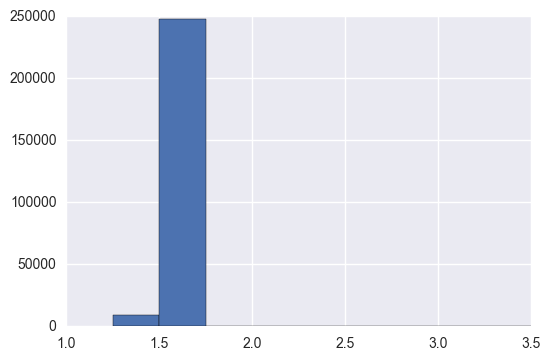

In [118]:
liquor_sales["Cost Ratio"] = liquor_sales["State Bottle Retail"] / liquor_sales["State Bottle Cost"]
liquor_sales["Cost Ratio"].hist()
print "Portion of ratios more than 5% away from the typical 50% mark-up : {0:.2f}%".format( 100. * \
                                  liquor_sales[(liquor_sales["Cost Ratio"] > 1.5*1.05) 
                                               | (liquor_sales["Cost Ratio"] < 1.5*.95)].shape[0] \
                                         / float(liquor_sales.shape[0]))

#### Beyond the existing price data, including the price per liter (PPL) should allow better per-unit comparison across all liquors than price per bottle.

In [121]:
liquor_sales["PPL"] = liquor_sales["Sale (Dollars)"] / liquor_sales["Volume Sold (Liters)"]

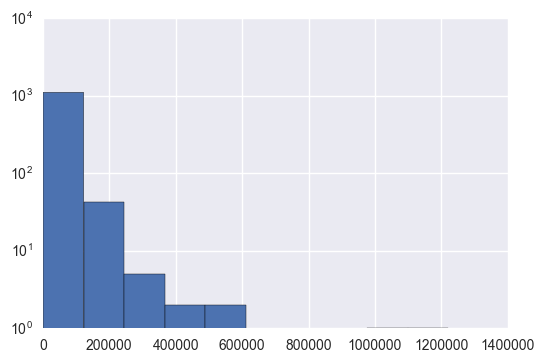

In [123]:
liquor_sales.groupby("Store Number")["Sale (Dollars)"].sum().hist(log=True)

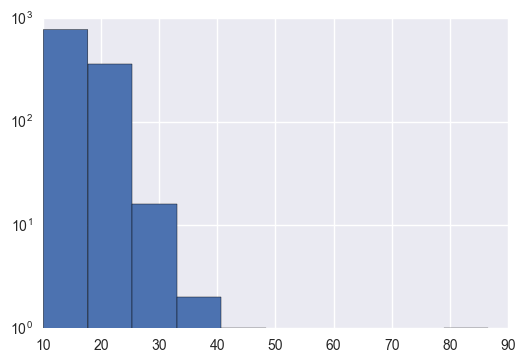

In [125]:
liquor_sales.groupby("Store Number")["PPL"].mean().hist(log=True)

## Record your findings

Be sure to write out anything observations from your exploratory analysis.

# Mine the data
Now you are ready to compute the variables you will use for your regression from the data. For example, you may want to
compute total sales per store from Jan to March of 2015, mean price per bottle, etc. Refer to the readme for more ideas appropriate to your scenario.

Pandas is your friend for this task. Take a look at the operations [here](http://pandas.pydata.org/pandas-docs/stable/groupby.html) for ideas on how to make the best use of pandas and feel free to search for blog and Stack Overflow posts to help you group data by certain variables and compute sums, means, etc. You may find it useful to create a new data frame to house this summary data.

# Refine the data
Look for any statistical relationships, correlations, or other relevant properties of the dataset.

# Build your models

Using scikit-learn or statsmodels, build the necessary models for your scenario. Evaluate model fit.

In [24]:
from sklearn import linear_model


## Plot your results

Again make sure that you record any valuable information. For example, in the tax scenario, did you find the sales from the first three months of the year to be a good predictor of the total sales for the year? Plot the predictions versus the true values and discuss the successes and limitations of your models

# Present the Results

Present your conclusions and results. If you have more than one interesting model feel free to include more than one along with a discussion. Use your work in this notebook to prepare your write-up.